In [17]:
from obspy import read
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt

In [18]:
st = read('./Data/*.sac')
st.trim(st[0].stats.starttime+50, st[0].stats.starttime+100, pad=True)
st.detrend('constant')
# fig = st.plot()
print(st.__str__(extended=True))

3 Trace(s) in Stream:
.0492..1 | 2002-03-26T21:06:26.784999Z - 2002-03-26T21:07:16.784999Z | 100.0 Hz, 5001 samples
.0492..2 | 2002-03-26T21:06:26.784999Z - 2002-03-26T21:07:16.784999Z | 100.0 Hz, 5001 samples
.0492..3 | 2002-03-26T21:06:26.784999Z - 2002-03-26T21:07:16.784999Z | 100.0 Hz, 5001 samples


In [19]:
v = st.select(channel='1')[0]
e = st.select(channel='3')[0]
n = st.select(channel='2')[0]
t = v.times()
dt = v.stats.delta
begintime = [0, 50]

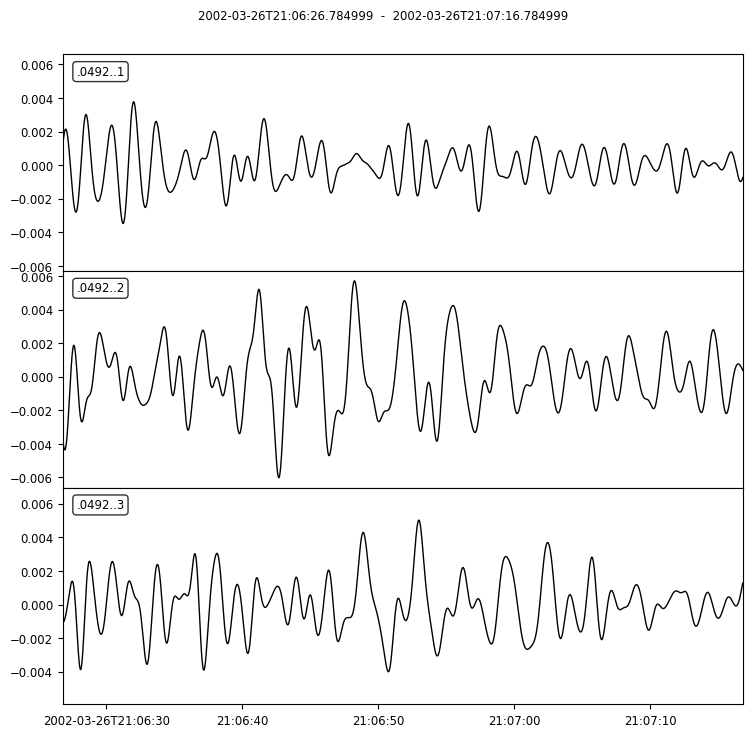

In [20]:
fig = st.plot()

In [21]:
fmin = 0.2
fmax = 2
fsteps = 50
cycles = 10
dfpar = 0.2


In [22]:
K = v.data.size
tau = dt #v.stats.delta
DTmax = 30
fnyq=1/(2*tau)
fstart = max(fmin,1/DTmax)
fend=min(fmax,fnyq)
flist=np.zeros(fsteps)
hsurv = np.zeros(fsteps)

In [23]:
constlog = (fend/fstart) ** (1/(fsteps-1))
fl=fstart*constlog ** np.arange(0, fsteps)
el=np.zeros(fsteps)

In [24]:
# print(fstart, constlog, np.arange(0, fsteps))
# print(fl)

In [25]:
vert=v
north=n
east=e
time=t

In [26]:
horizontalamp=np.zeros(fsteps)
verticalamp=np.zeros(fsteps)
horizontallist=np.zeros(fsteps)
verticallist=np.zeros(fsteps)
Tmax=max(time)

dim = (fsteps, math.ceil(Tmax*fend))
thetas=np.zeros(dim)
corr=np.zeros(dim)
# correlationlist=np.zeros(dim)
correlationlist= []

ampl=np.zeros(dim)
dvmax=np.zeros(fsteps)

In [27]:
correlationlist

[]

In [28]:
for findex in range(fsteps):
    f = fl[findex]
    df = dfpar * f
    fmin = max(fstart, f-df/2)
    fmax = min(fnyq, f+df/2)
    flist[findex] = f
    DT = cycles / f
    # print(cycles, f, DT, tau)
    wl = round(DT/tau)
    #
    wp = np.array([fmin+(fmax-fmin)/20, fmax-(fmax-fmin)/20]) / fnyq
    ws = np.array([fmin-(fmax-fmin)/20, fmax+(fmax-fmin)/20]) / fnyq
    na, wn = scipy.signal.cheb1ord(wp=wp, ws=ws, gpass=1, gstop=5, analog=False, fs=None)
    ch1, ch2 = scipy.signal.cheby1(na, 0.5, wn, btype='bandpass')
    #
    norths = scipy.signal.lfilter(ch1,ch2,north);
    easts = scipy.signal.lfilter(ch1,ch2,east);
    verts = scipy.signal.lfilter(ch1,ch2,vert);
    hsurv[findex] = np.sqrt((sum(norths**2)+sum(easts**2))/sum(verts**2))
    derive=(np.sign(verts[1: K]) - np.sign(verts[0: K-1])) / 2

    vertsum=np.zeros(wl)
    horsum=np.zeros(wl)
    dvindex=0
    ###                                                                                 # Checked 1402-08-11
    for index in range(math.ceil(1/(4*f*tau)), len(derive)-wl):
        # print(f'{findex=} {index=}')
        if derive[index]==1:
            dvindex=dvindex+1
            vsig=verts[index: index+wl]
            esig=easts[index-math.floor(1/(4*f*tau)): (index-math.floor(1/(4*f*tau))+wl)]
            nsig=norths[index-math.floor(1/(4*f*tau)): (index-math.floor(1/(4*f*tau))+wl)]
            integral1=sum(vsig*esig)
            integral2=sum(vsig*nsig)
            theta=np.arctan(integral1/integral2)
            if integral2<0:
                theta=theta+np.pi
            theta=np.mod(theta+np.pi,2*np.pi)
            hsig=math.sin(theta)*esig + math.cos(theta)*nsig
            correlation=sum(vsig*hsig)/np.sqrt(sum(vsig*vsig)*sum(hsig*hsig))
            if correlation>=-1:
                vertsum=vertsum+correlation**2*vsig
                horsum=horsum+correlation**2*hsig
            thetas[findex,dvindex] = theta
            correlationlist.append(correlation)
            corr[findex,dvindex] = correlation
            dvmax[findex]=dvindex
            ampl[findex,dvindex]=sum(vsig**2 + hsig**2)
    klimit=round(DT/tau)
    verticalamp[findex]=np.sqrt(sum(vertsum[0: klimit]**2))
    horizontalamp[findex]=np.sqrt(sum(horsum[0:klimit]**2))
    # break

ellist=horizontalamp/verticalamp

/tmp/ipykernel_9919/3013572413.py:54: RuntimeWarning: invalid value encountered in divide
  ellist=horizontalamp/verticalamp


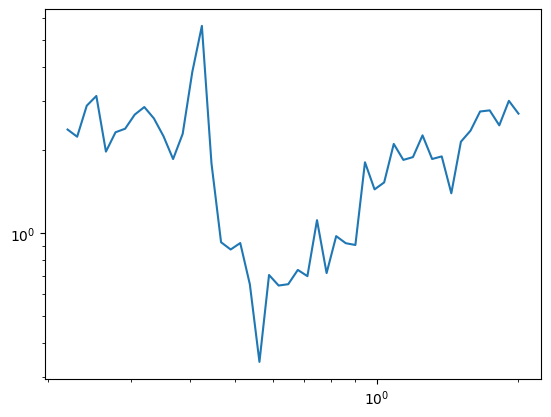

In [29]:
fl[:]=flist
el[:]=ellist

plt.loglog(fl,el)
plt.show()
